# Data Preprocessing and EDA

##    Libraries Import

In [1]:
import os

import warnings

import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *

from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.calibration import *
import joblib

pd.options.display.max_columns = 50
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.ensemble import BalancedRandomForestClassifier

%matplotlib inline
import seaborn as sns

sns.set()
from joblib import parallel_backend
from joblib.memory import Memory


def allow_stopping(func):
    def wrapper():
        try:
            value = func()
            return value
            # gc.collect()
        except KeyboardInterrupt as e:
            print("Program Stopped")
        gc.collect()

    return wrapper


import warnings

warnings.filterwarnings("ignore")

__refresh__ = 1


def run_if_refresh(func):
    def wrapper():
        global __refresh__
        if __refresh__ == 1:
            value = func()
            return value
        else:
            print(
                "Using Cache, Set Refresh to '__refresh__=1' to regenerate "
                "the output of this  function"
            )

    return wrapper


def gen_train_test(X, y, test_size):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=10
    )
    return X_train, X_test, y_train, y_test


def categorise_input(X: pd.DataFrame):
    X.loc[:, nominal + ordinal] = X.loc[:, nominal + ordinal].astype("category")
    return X


categoriser = FunctionTransformer(categorise_input, feature_names_out="one-to-one")


def quick_test(X):
    clfs = [
        RandomForestClassifier(class_weight="balanced_subsample", random_state=42),
        DecisionTreeClassifier(class_weight="balanced", random_state=42),
        HistGradientBoostingClassifier(random_state=42),
        LogisticRegressionCV(max_iter=1000, class_weight="balanced", random_state=42),
    ]
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.3)
    for clf in clfs:
        y_pred = clf.fit(X_train, y_train).predict(X_test)
        score = f1_score(y_test, y_pred, average="macro")
        print(f"{clf.__class__.__name__} :: {score}")


def find_correlated_features(df, threshold=0.8):
    correlated_features = set()
    correlation_matrix = df.corr()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)
    return list(correlated_features)

###    ColumnSelectors

In [2]:
class ColumnSelectors:
    def __init__(self, default=None):
        self.dtype_info = {
            "binary__v_1": "Binary",
            "binary__v_11": "Binary",
            "binary__v_14": "Binary",
            "binary__v_26": "Binary",
            "binary__v_27": "Binary",
            "binary__v_28": "Binary",
            "binary__v_30": "Binary",
            "binary__v_9": "Binary",
            "nominal__v_12": "Nominal",
            "nominal__v_18": "Nominal",
            "nominal__v_20": "Nominal",
            "nominal__v_21": "Nominal",
            "nominal__v_25": "Nominal",
            "nominal__v_3": "Nominal",
            "nominal__v_32": "Nominal",
            "nominal__v_4": "Nominal",
            "ordinal__v_0": "Ordinal",
            "ordinal__v_10": "Ordinal",
            "ordinal__v_13": "Ordinal",
            "ordinal__v_15": "Ordinal",
            "ordinal__v_17": "Ordinal",
            "ordinal__v_19": "Ordinal",
            "ordinal__v_22": "Ordinal",
            "ordinal__v_23": "Ordinal",
            "ordinal__v_24": "Ordinal",
            "ordinal__v_29": "Ordinal",
            "ordinal__v_31": "Ordinal",
            "ordinal__v_33": "Ordinal",
            "ordinal__v_5": "Ordinal",
            "ordinal__v_6": "Ordinal",
            "ratio__v_16": "Ratio",
            "ratio__v_2": "Ratio",
            "ratio__v_34": "Ratio",
            "ratio__v_35": "Ratio",
            "ratio__v_36": "Ratio",
            "ratio__v_37": "Ratio",
            "ratio__v_38": "Ratio",
            "ratio__v_39": "Ratio",
            "ratio__v_40": "Ratio",
            "ratio__v_7": "Ratio",
            "ratio__v_8": "Ratio",
        }

        self.ordinal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Ordinal"
        ]
        self.nominal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Nominal"
        ]
        self.binary_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Binary"
        ]
        self.ratio_cols = [i for i in self.dtype_info if self.dtype_info[i] == "Ratio"]
        self.ordinal = make_column_selector(
            pattern="|".join(self.ordinal_cols),
        )
        self.nominal = make_column_selector(
            pattern="|".join(self.nominal_cols),
        )
        self.binary = make_column_selector(
            pattern="|".join(self.binary_cols),
        )
        self.ratio = make_column_selector(
            pattern="|".join(self.ratio_cols),
        )

    def ordinal_selector(self):
        return self.ordinal

    def nominal_selector(self):
        return self.nominal

    def binary_selector(self):
        return self.binary

    def ratio_selector(self):
        return self.ratio

    def categorise_data(self, df: pd.DataFrame = None):
        """
        Categorise Data based on given data
        :params df : pandas.Dataframe
        """
        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.ordinal_cols]
            nominal_data = df.loc[:, self.nominal_cols]
            binary_data = df.loc[:, self.binary_cols]
            ratio_data = df.loc[:, self.ratio_cols]
        else:
            print("Please provide valid Data")
        return ordinal_data, nominal_data, binary_data, ratio_data


column_directory = ColumnSelectors()

###    Customised Polywrappers

In [3]:
import copy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
import category_encoders as encoders
import pandas as pd
import numpy as np
from abc import abstractmethod
from enum import Enum, auto

import sklearn.base
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.exceptions import NotFittedError
from typing import Dict, List, Optional, Union
from scipy.sparse import csr_matrix


def utils_convert_inputs(X, y, columns=None, index=None, deep=False):
    """
    Unite arraylike `X` and vectorlike `y` into a DataFrame and Series.
    If both are pandas types already, raises an error if their indexes do not match.
    If one is pandas, the returns will share that index.
    If neither is pandas, a default index will be used, unless `index` is passed.
    Parameters
    ----------
    X: arraylike
    y: listlike
    columns: listlike
        Specifies column names to use for `X`.
        Ignored if `X` is already a dataframe.
        If `None`, use the default pandas column names.
    index: listlike
        The index to use, if neither `X` nor `y` is a pandas type.
        (If one has an index, then this has no effect.)
        If `None`, use the default pandas index.
    deep: bool
        Whether to deep-copy `X`.
    """
    X_alt_index = y.index if isinstance(y, pd.Series) else index
    X = utils_convert_input(X, columns=columns, deep=deep, index=X_alt_index)
    if y is not None:
        y = utils_convert_input_vector(y, index=X.index)
        # N.B.: If either was already pandas, it keeps its index.

        if any(X.index != y.index):
            raise ValueError("`X` and `y` both have indexes, but they do not match.")
        if X.shape[0] != y.shape[0]:
            raise ValueError(
                "The length of X is "
                + str(X.shape[0])
                + " but length of y is "
                + str(y.shape[0])
                + "."
            )
    return X, y


def utils_convert_input(X, columns=None, deep=False, index=None):
    """
    Unite data into a DataFrame.
    Objects that do not contain column names take the names from the argument.
    Optionally perform deep copy of the data.
    """
    if not isinstance(X, pd.DataFrame):
        if isinstance(X, pd.Series):
            X = pd.DataFrame(X, copy=deep)
        else:
            if columns is not None and np.size(X, 1) != len(columns):
                raise ValueError(
                    "The count of the column names does not correspond to the count of the columns"
                )
            if isinstance(X, list):
                X = pd.DataFrame(
                    X, columns=columns, copy=deep, index=index
                )  # lists are always copied, but for consistency, we still pass the argument
            elif isinstance(X, (np.generic, np.ndarray)):
                X = pd.DataFrame(X, columns=columns, copy=deep, index=index)
            elif isinstance(X, csr_matrix):
                X = pd.DataFrame(X.todense(), columns=columns, copy=deep, index=index)
            else:
                raise ValueError(f"Unexpected input type: {type(X)}")
    elif deep:
        X = X.copy(deep=True)

    return X


def utils_convert_input_vector(y, index):
    """
    Unite target data type into a Series.
    If the target is a Series or a DataFrame, we preserve its index.
    But if the target does not contain index attribute, we use the index from the argument.
    """
    if y is None:
        raise ValueError(
            "Supervised encoders need a target for the fitting. The target cannot be None"
        )
    if isinstance(y, pd.Series):
        return y
    elif isinstance(y, np.ndarray):
        if len(np.shape(y)) == 1:  # vector
            return pd.Series(y, name="target", index=index)
        elif len(np.shape(y)) == 2 and np.shape(y)[0] == 1:  # single row in a matrix
            return pd.Series(y[0, :], name="target", index=index)
        elif len(np.shape(y)) == 2 and np.shape(y)[1] == 1:  # single column in a matrix
            return pd.Series(y[:, 0], name="target", index=index)
        else:
            raise ValueError(f"Unexpected input shape: {np.shape(y)}")
    elif np.isscalar(y):
        return pd.Series([y], name="target", index=index)
    elif isinstance(y, list):
        if len(y) == 0:  # empty list
            return pd.Series(y, name="target", index=index, dtype=float)
        elif len(y) > 0 and not isinstance(y[0], list):  # vector
            return pd.Series(y, name="target", index=index)
        elif (
            len(y) > 0 and isinstance(y[0], list) and len(y[0]) == 1
        ):  # single row in a matrix
            flatten = lambda y: [item for sublist in y for item in sublist]
            return pd.Series(flatten(y), name="target", index=index)
        elif (
            len(y) == 1 and len(y[0]) == 0 and isinstance(y[0], list)
        ):  # single empty column in a matrix
            return pd.Series(y[0], name="target", index=index, dtype=float)
        elif len(y) == 1 and isinstance(y[0], list):  # single column in a matrix
            return pd.Series(y[0], name="target", index=index, dtype=type(y[0][0]))
        else:
            raise ValueError("Unexpected input shape")
    elif isinstance(y, pd.DataFrame):
        if len(list(y)) == 0:  # empty DataFrame
            return pd.Series(name="target", index=index, dtype=float)
        if len(list(y)) == 1:  # a single column
            return y.iloc[:, 0]
        else:
            raise ValueError(f"Unexpected input shape: {y.shape}")
    else:
        return pd.Series(
            y, name="target", index=index
        )  # this covers tuples and other directly convertible types


class PolynomialWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, feature_encoder):
        self.feature_encoder = feature_encoder
        self.feature_encoders = {}
        self.label_encoder = None

    def fit(self, X, y, **kwargs):
        # unite the input into pandas types
        X, y = utils_convert_inputs(X, y)
        y = pd.DataFrame(y, columns=["target"])

        # apply one-hot-encoder on the label
        self.label_encoder = encoders.OneHotEncoder(
            handle_missing="error",
            handle_unknown="error",
            cols=["target"],
            drop_invariant=False,
            use_cat_names=True,
        )
        labels = self.label_encoder.fit_transform(y)
        labels.columns = [column[7:] for column in labels.columns]
        # labels = labels.iloc[:, 1:]  # drop one label

        # train the feature encoders
        for class_name, label in labels.iteritems():
            self.feature_encoders[class_name] = copy.deepcopy(self.feature_encoder).fit(
                X, label
            )

    def transform(self, X):
        # unite the input into pandas types
        X = utils_convert_input(X)

        # initialization
        encoded = None
        feature_encoder = None
        all_new_features = pd.DataFrame()

        # transform the features
        for class_name, feature_encoder in self.feature_encoders.items():
            encoded = feature_encoder.transform(X)

            # decorate the encoded features with the label class suffix
            new_features = encoded[feature_encoder.cols]
            new_features.columns = [
                str(column) + "_" + class_name for column in new_features.columns
            ]

            all_new_features = pd.concat((all_new_features, new_features), axis=1)

        # add features that were not encoded
        result = pd.concat(
            (
                encoded[encoded.columns[~encoded.columns.isin(feature_encoder.cols)]],
                all_new_features,
            ),
            axis=1,
        )

        return result

    def fit_transform(self, X, y=None, **fit_params):
        # When we are training the feature encoders, we have to use fit_transform() method on the features.

        # unite the input into pandas types
        X, y = utils_convert_inputs(X, y)
        y = pd.DataFrame(y, columns=["target"])

        # apply one-hot-encoder on the label
        self.label_encoder = encoders.OneHotEncoder(
            handle_missing="error",
            handle_unknown="error",
            cols=["target"],
            drop_invariant=True,
            use_cat_names=True,
        )
        labels = self.label_encoder.fit_transform(y)
        labels.columns = [column[7:] for column in labels.columns]
        # labels = labels.iloc[:, 1:]  # drop one label

        # initialization of the feature encoders
        encoded = None
        feature_encoder = None
        all_new_features = pd.DataFrame()

        # fit_transform the feature encoders
        for class_name, label in labels.iteritems():
            feature_encoder = copy.deepcopy(self.feature_encoder)
            encoded = feature_encoder.fit_transform(X, label)

            # decorate the encoded features with the label class suffix
            new_features = encoded[feature_encoder.cols]
            new_features.columns = [
                str(column) + "_" + class_name for column in new_features.columns
            ]

            all_new_features = pd.concat((all_new_features, new_features), axis=1)
            self.feature_encoders[class_name] = feature_encoder

        # add features that were not encoded
        result = pd.concat(
            (
                encoded[encoded.columns[~encoded.columns.isin(feature_encoder.cols)]],
                all_new_features,
            ),
            axis=1,
        )

        return result

## Prepare Data and Execution Enviroment

### Rename Columns and Start Data Save

In [4]:
DATA_PATH = "/kaggle/input/students-drop-out-prediction/"
DATA_SAVE_PATH = "/kaggle/working/"
TRAIN_DATA = "train.csv"
TEST_DATA = "test.csv"
KAGGLE_ENV = 1

cwd = os.path.abspath(os.getcwd())
if "mlop3n/Pycharm" in cwd:
    KAGGLE_ENV = 0

if KAGGLE_ENV == 0:
    LOCAL_PATH = "../data"
    DATA_PATH = LOCAL_PATH + DATA_PATH
    DATA_SAVE_PATH = LOCAL_PATH + DATA_SAVE_PATH


def write_raw_data(raw_data: pd.DataFrame, raw_data_eval: pd.DataFrame):
    global DATA_SAVE_PATH
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")


# TODO rerun this script to rename the target column


def reload_raw_data():
    global DATA_SAVE_PATH
    raw_data = pd.read_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval = pd.read_parquet(DATA_SAVE_PATH + "test.parquet")
    return raw_data, raw_data_eval


@run_if_refresh
def rename_columns_with_dtype(DATA_PATH=DATA_PATH, DATA_SAVE_PATH=DATA_SAVE_PATH):
    raw_data = pd.read_csv(DATA_PATH + TRAIN_DATA, index_col=0)
    raw_data_eval = pd.read_csv(DATA_PATH + TEST_DATA, index_col=0)

    raw_dtypes_info = {}
    saved_dtypes_info = column_directory.dtype_info
    for k, v in saved_dtypes_info.items():
        tmp = k.split("__")
        data_type = tmp[0]
        column_name = tmp[1]
        raw_dtypes_info[column_name] = k

    raw_data.rename(columns=raw_dtypes_info, inplace=True)
    raw_data_eval.rename(columns=raw_dtypes_info, inplace=True)
    raw_data.rename(columns={"label": "target"}, inplace=True)
    write_raw_data(raw_data, raw_data_eval)
    # raw_data.to_parquet(DATA_SAVE_PATH+'train.parquet')
    # raw_data_eval.to_parquet(DATA_SAVE_PATH+'test.parquet')


rename_columns_with_dtype()

### Load Renamed Data

In [5]:
raw_data, raw_data_eval = reload_raw_data()

### Load Metadata

In [6]:
ordinal = column_directory.ordinal_cols
nominal = column_directory.nominal_cols
binary = column_directory.binary_cols
ratios = column_directory.ratio_cols

ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(
    raw_data
)
(
    ordinal_data_eval,
    nominal_data_eval,
    binary_data_eval,
    ratios_data_eval,
) = column_directory.categorise_data(raw_data_eval)

### Define Baseline Test

In [20]:
X = raw_data.drop(["target"], axis=1)
y = raw_data.target

In [7]:
def baseline(raw_data=raw_data):
    X = raw_data.drop(["target"], axis=1)
    y = raw_data.target
    # quick_test(X)
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.4)

    random_forest = BalancedRandomForestClassifier(random_state=10)
    tmp_clf = make_pipeline(
        RFE(
            estimator=BalancedRandomForestClassifier(random_state=42),
            n_features_to_select=50,
        ),
        AdaBoostClassifier(
            base_estimator=random_forest, n_estimators=4, random_state=10
        ),
    )
    with parallel_backend("loky"):
        y_pred = tmp_clf.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test, y_pred))
        scores = cross_validate(
            tmp_clf,
            X,
            y,
            cv=StratifiedKFold(n_splits=4),
            n_jobs=-1,
            scoring="f1_macro",
            return_train_score=True,
        )
        print("F1_Train", scores["train_score"].mean())
        print("F1_Test", scores["test_score"].mean())


baseline()

              precision    recall  f1-score   support

           0       0.84      0.63      0.72       497
           1       0.80      0.81      0.81       746
           2       0.43      0.61      0.51       276

    accuracy                           0.72      1519
   macro avg       0.69      0.68      0.68      1519
weighted avg       0.75      0.72      0.72      1519

F1_Train 0.9797734685137968
F1_Test 0.6809945271904871


## Transformations
 - <mark>__Scale Down Ordinal Data By Substracting all samples with Global Feature Minimum__</mark>
 - <mark>__Sort Columns by Name for better visibility__</mark>
 - <mark>__Ordinally Encode Nominal Data to reduce categorical distance within a feature__</mark>
 - <mark>__Add a Column - Sum of all Binary Features along x-axis__</mark>
 - <mark>__Standardise the Ratio Features using Quantile Transformeer__</mark>

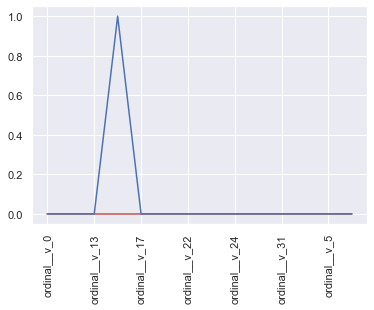

In [8]:
@run_if_refresh
def update_ordinal_data():
    categorical_columns = [ordinal, nominal]
    ordinal_data = raw_data.loc[:, ordinal].copy()
    ordinal_data_eval = raw_data_eval.loc[:, ordinal].copy()
    raw_data.loc[:, ordinal] = ordinal_data - ordinal_data.min()
    raw_data_eval.loc[:, ordinal] = ordinal_data_eval - ordinal_data.min()
    # update_categorical_data()
    # disp = raw_data.loc[:, ordinal].min().plot(color="r", rot=90)
    # disp = raw_data_eval.loc[:, ordinal].min().plot(rot=90)
    write_raw_data(raw_data, raw_data_eval)

@run_if_refresh
def sort_columns_by_name(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data = raw_data.sort_index(axis=1)
    raw_data_eval = raw_data_eval.sort_index(axis=1)
    raw_data.to_parquet(DATA_SAVE_PATH + "train.parquet")
    raw_data_eval.to_parquet(DATA_SAVE_PATH + "test.parquet")

@run_if_refresh
def ordinally_encode_nominal_data():
    ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=125)
    nominal_enc_data = ordinal_enc.fit_transform(raw_data.loc[:, nominal])
    nominal_enc_data_eval = ordinal_enc.transform(raw_data_eval.loc[:, nominal])
    raw_data.loc[:, nominal] = nominal_enc_data
    raw_data_eval.loc[:, nominal] = nominal_enc_data_eval
    write_raw_data(raw_data, raw_data_eval)
@run_if_refresh
def binary_feature_sum(raw_data=raw_data, raw_data_eval=raw_data_eval):
    raw_data["binary_sum"] = raw_data.loc[:, binary].sum(axis=1)
    raw_data_eval["binary_sum"] = raw_data_eval.loc[:, binary].sum(axis=1)
    write_raw_data(raw_data, raw_data_eval)

@run_if_refresh
def standardise_ratio_features(
    raw_data=raw_data.copy(), raw_data_eval=raw_data_eval.copy()
):
    # Load Data
    payload = raw_data.loc[:, ratios]
    payload_eval = raw_data_eval.loc[:, ratios]
    # Define Scaling Method
    scaler1 = QuantileTransformer(
        output_distribution="normal", random_state=42, n_quantiles=1000
    )
    scaler2 = KBinsDiscretizer(
        encode="onehot-dense", random_state=10, n_bins=3, strategy="kmeans"
    )
    # mscaler = make_pipeline(scaler1,scaler2)
    mscaler = StandardScaler()
    # Apply Scaling
    payload_t = mscaler.fit_transform(payload)
    payload_eval_t = mscaler.transform(payload_eval)
    # New Column Names
    new_ordinal_col_names = mscaler.get_feature_names_out()
    new_ordinal_col_names = [x.replace(".", "_") for x in new_ordinal_col_names]
    # Create Dataframe with new features to concatenate
    tmp_raw_data = pd.DataFrame(
        payload_t, columns=new_ordinal_col_names, index=raw_data.index
    ).astype("int")
    tmp_raw_data_eval = pd.DataFrame(
        payload_eval_t, columns=new_ordinal_col_names, index=raw_data_eval.index
    ).astype("int")
    # Concatenate in place
    raw_data = pd.concat([tmp_raw_data, raw_data.drop(ratios, axis=1)], axis=1)
    raw_data_eval = pd.concat(
        [tmp_raw_data_eval, raw_data_eval.drop(ratios, axis=1)], axis=1
    )
    # Write modified data to disk
    write_raw_data(raw_data, raw_data_eval)
    # return raw_data
    

@run_if_refresh
def apply_transformations():
    update_ordinal_data()
    sort_columns_by_name()
    ordinally_encode_nominal_data()    
    binary_feature_sum()
    standardise_ratio_features()
    
apply_transformations()
raw_data, raw_data_eval = reload_raw_data()

In [9]:
baseline(raw_data)

              precision    recall  f1-score   support

           0       0.84      0.63      0.72       497
           1       0.80      0.81      0.81       746
           2       0.43      0.61      0.51       276

    accuracy                           0.72      1519
   macro avg       0.69      0.68      0.68      1519
weighted avg       0.75      0.72      0.72      1519

F1_Train 0.9797734685137968
F1_Test 0.6809945271904871


### Nominal Feature Engg

In [21]:
"""
8 Nominal Features
Baseline Performance: 
              precision    recall  f1-score   support

           0       0.46      0.44      0.45       497
           1       0.62      0.49      0.54       746
           2       0.24      0.39      0.30       276

    accuracy                           0.45      1519
   macro avg       0.44      0.44      0.43      1519
weighted avg       0.50      0.45      0.47      1519

F1_Train 0.9011832457876175
F1_Test 0.43304228047789883
"""


classifiers = [
    ("AdaBoostClassifier", sklearn.ensemble._weight_boosting.AdaBoostClassifier),
    ("BernoulliNB", sklearn.naive_bayes.BernoulliNB),
    ("CategoricalNB", sklearn.naive_bayes.CategoricalNB),
    ("ComplementNB", sklearn.naive_bayes.ComplementNB),
    ("DecisionTreeClassifier", sklearn.tree._classes.DecisionTreeClassifier),
    ("DummyClassifier", sklearn.dummy.DummyClassifier),
    ("ExtraTreeClassifier", sklearn.tree._classes.ExtraTreeClassifier),
    ("ExtraTreesClassifier", sklearn.ensemble._forest.ExtraTreesClassifier),
    ("GaussianNB", sklearn.naive_bayes.GaussianNB),
    (
        "GaussianProcessClassifier",
        sklearn.gaussian_process._gpc.GaussianProcessClassifier,
    ),
    ("GradientBoostingClassifier", sklearn.ensemble._gb.GradientBoostingClassifier),
    (
        "HistGradientBoostingClassifier",
        sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier,
    ),
    ("KNeighborsClassifier", sklearn.neighbors._classification.KNeighborsClassifier),
  
    ("LinearSVC", sklearn.svm._classes.LinearSVC),
    ("LogisticRegression", sklearn.linear_model._logistic.LogisticRegression),
    ("LogisticRegressionCV", sklearn.linear_model._logistic.LogisticRegressionCV),
    ("MLPClassifier", sklearn.neural_network._multilayer_perceptron.MLPClassifier),
    ("MultinomialNB", sklearn.naive_bayes.MultinomialNB),
    ("NearestCentroid", sklearn.neighbors._nearest_centroid.NearestCentroid),
    ("NuSVC", sklearn.svm._classes.NuSVC),

    (
        "PassiveAggressiveClassifier",
        sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier,
    ),
    ("Perceptron", sklearn.linear_model._perceptron.Perceptron),
   
    (
        "RadiusNeighborsClassifier",
        sklearn.neighbors._classification.RadiusNeighborsClassifier,
    ),
    ("RandomForestClassifier", sklearn.ensemble._forest.RandomForestClassifier),
    ("RidgeClassifier", sklearn.linear_model._ridge.RidgeClassifier),
    ("RidgeClassifierCV", sklearn.linear_model._ridge.RidgeClassifierCV),
    ("SGDClassifier", sklearn.linear_model._stochastic_gradient.SGDClassifier),
    ("SVC", sklearn.svm._classes.SVC),
  
]

In [23]:
X= raw_data.loc[:,nominal]
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X,y,test_size=0.5)
def baseline_clf_headstart(X,y):
    perf = {}
    for clf_name,clf in classifiers:
        with parallel_backend('threading'):
            try:
                scores = cross_validate(OneVsRestClassifier(clf(),n_jobs=-1),X,y,cv=3,scoring='f1_macro',n_jobs=-1,return_train_score=True)
                perf[clf_name] = {
                    "test_score" : scores['test_score'].mean(),
                    "train_score": scores['train_score'].mean()
                }
            except:
                perf[clf_name] = {
                "test_score" : 0,
                "train_score": 0
            }


```python
scores = cross_validate(OneVsRestClassifier(CategoricalNB(min_categories=X.nunique(),fit_prior=True),n_jobs=-1),X,y,cv=5,scoring='f1_macro',n_jobs=-1,return_train_score=True)
```

In [34]:
def rf_apply(X, model):
    return model.apply(X)


random_forest = BalancedRandomForestClassifier(
    class_weight="balanced_subsample",
    n_jobs=-1,
    max_leaf_nodes=6,
    n_estimators=100,
    # max_depth=12,
    # max_features=None,
)
random_forest.fit(X_train, y_train)
rf_leaves_yielder = FunctionTransformer(rf_apply, kw_args={"model": random_forest})

rf_model_hasher = make_pipeline(
    rf_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False),
)
rf_model_hasher


workflow=Pipeline([
    ("hasher",rf_model_hasher),
    # ("dim_reduce",FeatureAgglomeration(n_clusters=30,memory=Memory(DATA_SAVE_PATH,verbose=0),affinity='manhattan',linkage='average')),
    ("esimator",LogisticRegressionCV(max_iter=2000,class_weight='balanced',random_state=42))
    # ("esimator",OneVsRestClassifier(SGDClassifier(max_iter=2000,class_weight='balanced',random_state=42,n_jobs=-1,)))
    # ("esimator",OneVsRestClassifier(SVC(random_state=10)))
    # ("esimator",BalancedRandomForestClassifier(random_state=10))
],
    memory=Memory(DATA_SAVE_PATH,verbose=0)

)
workflow

with parallel_backend('threading'):
    y_pred = workflow.fit(X_train, y_train).predict(X_test)
    score = f1_score(y_test, y_pred, average="macro")
score

0.43103903304854724

In [39]:
X.nunique()

nominal__v_12     37
nominal__v_18     95
nominal__v_20     98
nominal__v_21     22
nominal__v_25     80
nominal__v_3     124
nominal__v_32     84
nominal__v_4      98
dtype: int64

### Scaling Ordinal Values using Quantile Transformer

In [21]:
@run_if_refresh
def generate_scaled_ordinal_features(raw_data=raw_data, raw_data_eval=raw_data_eval):
    # scaler = QuantileTransformer(output_distribution='normal',random_state=42,n_quantiles=44
    scaler = QuantileTransformer(n_quantiles=24)
    # dataset = scaler.fit_transform(raw_data.loc[:,ordinal])
    payload = raw_data.loc[:, ordinal]
    payload_eval = raw_data_eval.loc[:, ordinal]
    payload_t = scaler.fit_transform(payload)
    payload_eval_t = scaler.transform(payload_eval)
    new_ordinal_col_names = ordinal
    tmp_raw_data = pd.DataFrame(
        payload_t, columns=new_ordinal_col_names, index=raw_data.index
    )
    tmp_raw_data_eval = pd.DataFrame(
        payload_eval_t, columns=new_ordinal_col_names, index=raw_data_eval.index
    )
    raw_data = pd.concat([tmp_raw_data, raw_data.drop(ordinal, axis=1)], axis=1)
    raw_data_eval = pd.concat(
        [tmp_raw_data_eval, raw_data_eval.drop(ordinal, axis=1)], axis=1
    )
    # print(raw_data.shape)
    return raw_data
    # write_raw_data(raw_data, raw_data_eval)


# tP = generate_scaled_ordinal_features()
# raw_data, raw_data_eval = reload_raw_data()

# baseline(tP)

### Removing Correlated Features

In [169]:
@run_if_refresh
def remove_correlated_features(raw_data=raw_data, raw_data_eval=raw_data_eval):
    threshold = 0.7
    correlated_features = set()
    categorical_correlation = raw_data.corr()
    for i in range(len(categorical_correlation.columns)):
        for j in range(i):
            if abs(categorical_correlation.iloc[i, j]) > threshold:
                colname = categorical_correlation.columns[i]
                correlated_features.add(colname)
    raw_data.drop(correlated_features, axis=1, inplace=True)
    raw_data_eval.drop(correlated_features, axis=1, inplace=True)
    return raw_data
    # write_raw_data(raw_data, raw_data_eval)


# tP = remove_correlated_features()
# raw_data, raw_data_eval = reload_raw_data()

In [56]:
new_ordinal_col_names = ["scaled__" + x for x in ordinal]
dict(zip(new_ordinal_col_names, ordinal))

{'scaled__ordinal__v_0': 'ordinal__v_0',
 'scaled__ordinal__v_10': 'ordinal__v_10',
 'scaled__ordinal__v_13': 'ordinal__v_13',
 'scaled__ordinal__v_15': 'ordinal__v_15',
 'scaled__ordinal__v_17': 'ordinal__v_17',
 'scaled__ordinal__v_19': 'ordinal__v_19',
 'scaled__ordinal__v_22': 'ordinal__v_22',
 'scaled__ordinal__v_23': 'ordinal__v_23',
 'scaled__ordinal__v_24': 'ordinal__v_24',
 'scaled__ordinal__v_29': 'ordinal__v_29',
 'scaled__ordinal__v_31': 'ordinal__v_31',
 'scaled__ordinal__v_33': 'ordinal__v_33',
 'scaled__ordinal__v_5': 'ordinal__v_5',
 'scaled__ordinal__v_6': 'ordinal__v_6'}

## Categorical Correlation and Feature Engineering

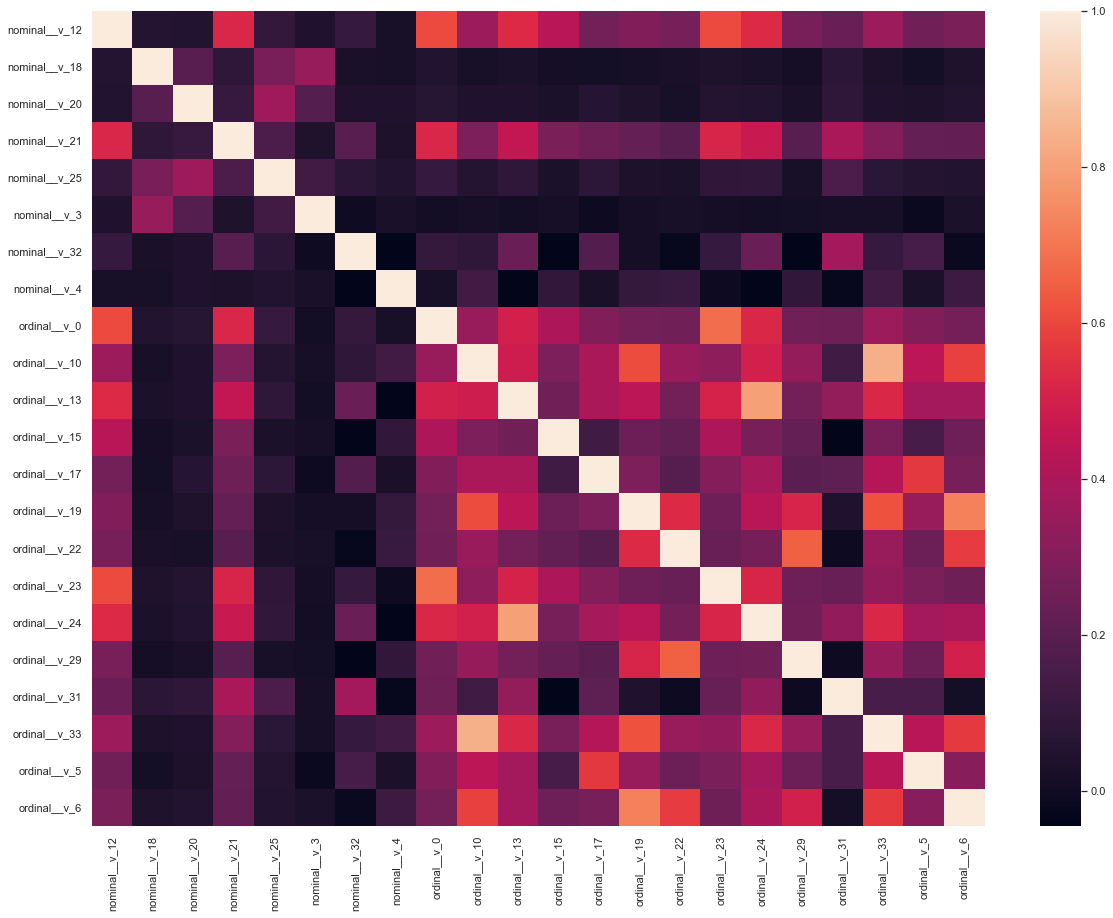

In [57]:
categorical_correlation = raw_data.loc[:, nominal + ordinal].corr(method="kendall")
plt.figure(figsize=(20, 15))
disp = sns.heatmap(
    categorical_correlation,
    robust=True,
)

```text
From the HeatMap it is evident that ordinal data and nominal data has interactions. They also correlate well above the threshold. Hence Examining Features which correlate with features and the effect of removing them is needed to Be explored
```

In [147]:
smote_enn = SMOTEENN(random_state=0)
X = raw_data.drop(["target"], axis=1)
y = raw_data.target
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
nm1 = NearMiss(version=1)
X_resampled, y_resampled = nm1.fit_resample(X, y)
# print(sorted(Counter(y_resampled).items()))

In [285]:
X = raw_data.drop(["target"], axis=1)
y = raw_data.target
X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.4)


sampler = SMOTEENN(random_state=0)
hasher = RandomTreesEmbedding(
    n_estimators=5, max_depth=5, sparse_output=False, n_jobs=-1, random_state=43
)
clf = make_pipeline(
    hasher,
    LogisticRegressionCV(
        max_iter=20000,
        random_state=43,
        class_weight="balanced",
        scoring="f1_macro",
        n_jobs=-1,
    ),
)
clf = make_imb_pipeline(
    hasher,
    sampler,
    SVC(
        kernel="rbf",
        break_ties=True,
        class_weight="balanced",
        random_state=32,
        cache_size=1024,
        probability=True,
    ),
)


from imblearn.ensemble import BalancedRandomForestClassifier


def rf_apply(X, model):
    # model.fit(X, y)
    return model.apply(X)


random_forest = BalancedRandomForestClassifier(
    class_weight="balanced_subsample",
    criterion="gini",
    n_jobs=-1,
    n_estimators=50,
    # max_samples=0.3,
    max_depth=None,
    max_leaf_nodes=3,
    # ccp_alpha=0.001,
    # min_samples_split=20,
    # max_features=None,
)
sampler = SMOTEENN(random_state=0)
sampler = SMOTETomek(random_state=0)
sampler = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
random_forest.fit(X_resampled, y_resampled)
rf_leaves_yielder = FunctionTransformer(rf_apply, kw_args={"model": random_forest})

rf_model_hasher = make_pipeline(
    rf_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

clf = make_pipeline(
    rf_model_hasher,
    OneVsOneClassifier(CategoricalNB(fit_prior=False, min_categories=2), n_jobs=-1),
)
clf = make_pipeline(
    rf_model_hasher,
    OneVsOneClassifier(
        BernoulliNB(alpha=0.00000001, fit_prior=False, binarize=False), n_jobs=-1
    ),
)
# clf = make_pipeline(rf_model_hasher,LogisticRegressionCV(max_iter=20000,random_state=43,class_weight='balanced',scoring='f1_macro',n_jobs=-1))
# clf = make_pipeline(rf_model_hasher, OneVsRestClassifier(GaussianNB(),n_jobs=-1))
# nm1 = SMOTETomek(random_state=0)
# X_train, y_train = nm1.fit_resample(X_train, y_train)
# clf = rf_model
with parallel_backend("loky"):
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.56      0.66       497
           1       0.72      0.87      0.79       746
           2       0.40      0.41      0.41       276

    accuracy                           0.68      1519
   macro avg       0.65      0.61      0.62      1519
weighted avg       0.69      0.68      0.68      1519



In [286]:
y_pred = clf.predict(raw_data_eval)
make_submission(y_pred)

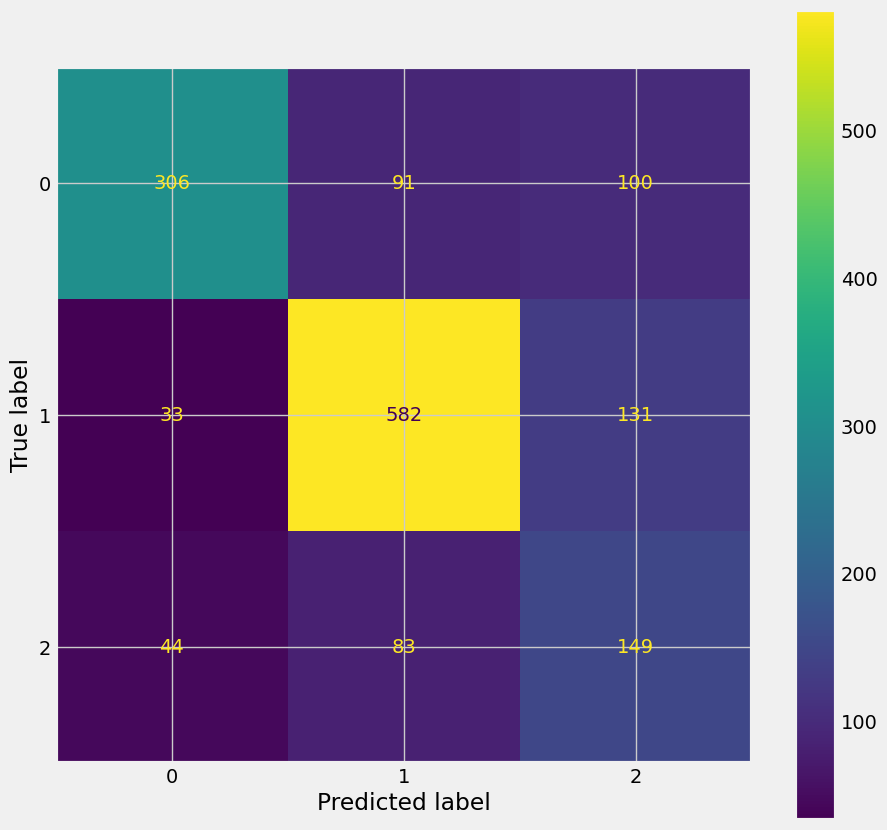

In [278]:
# confusion_mat = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,10))
plt.style.use("fivethirtyeight")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="viridis")

In [273]:
tmp_clf = make_pipeline(
    RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=50),
    AdaBoostClassifier(base_estimator=random_forest, n_estimators=30),
)
with parallel_backend("loky"):
    y_pred = tmp_clf.fit(X_train, y_train).predict(X_test)
    print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.65      0.74       249
           1       0.81      0.80      0.80       373
           2       0.42      0.62      0.50       138

    accuracy                           0.72       760
   macro avg       0.70      0.69      0.68       760
weighted avg       0.75      0.72      0.73       760



In [17]:
# y_pred = tmp_clf.predict(raw_data_eval)
def make_submission(y):
    y_df = pd.DataFrame(y, columns=["label"])
    y_df.to_csv(
        DATA_SAVE_PATH + "submission.csv",
    )

In [276]:
make_submission(y_pred)

In [237]:
rf_model_hasher.fit_transform(X_train, y_train).shape

(2657, 200)

##    Load Data Prepared Data

In [28]:
import pandas as pd


class DFCollection:
    """
    Contains all the data used.
    Upon Init all data gets loaded.
    Save method is also provided.
    """

    def __init__(self):
        self.c_sel = ColumnSelectors()

        self.file_path = "/kaggle/working/"
        if KAGGLE_ENV == 0:
            self.file_path = "../data" + self.file_path
        self.data = pd.read_parquet(self.file_path + "train.parquet")
        self.prediction_data = pd.read_parquet(self.file_path + "test.parquet")
        self.data_logits = pd.read_parquet(self.file_path + "data_with_ridit.hdfs")
        self.final_data = pd.read_parquet(self.file_path + "final_data.parquet")
        self.final_pred_data = pd.read_parquet(
            self.file_path + "final_pred_data.parquet"
        )

        self.core_frames = [
            self.data,
            self.prediction_data,
            self.data_logits,
            self.final_data,
        ]
        save_paths = [
            "train.parquet",
            "test.parquet",
            "data_with_ridit.hdfs",
            "final_data.parquet",
            "final_pred_data.parquet",
        ]
        self.save_paths = [self.file_path + x for x in save_paths]
        self.core_names = [x.split(".")[0] for x in self.save_paths]
        self.final_data.rename(columns={"label": "target"}, inplace=True)
        self.data.rename(columns={"label": "target"}, inplace=True)
        self.nominal_categories = {}
        for nc in self.c_sel.nominal_cols:
            ncs = self.master.loc[:, nc].unique()
            self.nominal_categories[nc] = ncs

        self.ordinal_categories = {}
        for nc in self.c_sel.ordinal_cols:
            ncs = self.master.loc[:, nc].unique()
            self.ordinal_categories[nc] = ncs

    @staticmethod
    def __save__(df: pd.DataFrame, loc: str):
        try:
            df.to_parquet(loc)
        except:
            return "Save Failed"
        return "Saved Successfully"

    def save_all(self):
        """
        Before Saving all objects ask question for each of them.
        And for each question if the answer is yes proceed to save otherwise continue.
        """
        exit_msg = "Exiting!"
        try:
            for df_name, df, df_loc in zip(
                self.core_names, self.core_frames, self.save_paths
            ):
                base_question = f"Do you want to save {df_name}?(Yes/No/Exit)"
                skip_msg = f"Skipping {df_name}"
                while True:
                    answer = input(base_question)
                    if answer == "Yes":
                        msg = self.__save__(df, df_loc)
                        print(df_name + msg)
                        break
                    elif answer in ["No", "n"]:
                        print(skip_msg)
                        break
                    elif answer in ["Exit", "e"]:
                        print(exit_msg)
                        return
                    else:
                        print("Not Valid Input")
                        continue
        except KeyboardInterrupt:
            print(exit_msg)
            return

    def categorise_data(self, df: pd.DataFrame = None):

        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.c_sel.ordinal_cols]
            nominal_data = df.loc[:, self.c_sel.nominal_cols]
            binary_data = df.loc[:, self.c_sel.binary_cols]
            ratio_data = df.loc[:, self.c_sel.ratio_cols]
        else:
            df = self.final_data
            ordinal_data = df.loc[:, self.c_sel.ordinal_cols]
            nominal_data = df.loc[:, self.c_sel.nominal_cols]
            binary_data = df.loc[:, self.c_sel.binary_cols]
            ratio_data = df.loc[:, self.c_sel.ratio_cols]
        return ordinal_data, nominal_data, binary_data, ratio_data


# if __name__ == "__main__":
#     db = DFCollection()

## Saved Standalone Models

### Categorical HistGradientBoostingClassifier

In [200]:
used_columns = []


def get_column_selection_pattern_HBGC(raw_data=raw_data, threshold=0.9):
    global used_columns
    correlated_features = set()
    categorical_correlation = raw_data.loc[:, nominal + ordinal].corr(method="kendall")
    for i in range(len(categorical_correlation.columns)):
        for j in range(i):
            if abs(categorical_correlation.iloc[i, j]) > threshold:
                colname = categorical_correlation.columns[i]
                correlated_features.add(colname)

    used_columns = list(set(ordinal + nominal) - correlated_features)
    column_selection_pattern = "|".join(used_columns)
    return column_selection_pattern


helpers = {
    "column_selector": make_column_selector(
        pattern=get_column_selection_pattern_HBGC()
    ),
    "categorical_mask": [True] * 22,
}
ct = ColumnTransformer(
    transformers=[("select_used_columns", "passthrough", helpers["column_selector"])],
    n_jobs=-1,
    sparse_threshold=0,
)
clf_hist_gbc = OneVsRestClassifier(
    estimator=HistGradientBoostingClassifier(
        random_state=42,
        max_bins=255,
        learning_rate=0.1,
        l2_regularization=0.9,
        scoring="f1_macro",
        categorical_features=helpers["categorical_mask"],
    ),
    n_jobs=-1,
)
HistGBC_pipeline = Pipeline(
    steps=[("columntransformer", ct), ("onevsrestclassifier", clf_hist_gbc)],
    memory=joblib.Memory(),
)


@run_if_refresh
def test_model(model=HistGBC_pipeline):
    """
    Test: HistGBC_pipeline
    """
    # X = raw_data.loc[:,nominal+ordinal]
    X = raw_data.drop(["target"], axis=1)
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.3)

    with parallel_backend("loky"):
        # model = HistGBC_pipeline
        y_pred = model.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test, y_pred, labels=[0, 1, 2]))
        scores = cross_validate(
            model,
            X,
            y,
            scoring="f1_macro",
            n_jobs=-1,
            return_train_score=True,
            return_estimator=True,
            error_score=0,
            cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=3),
        )
        mean_f1_score_test = scores["test_score"].mean()
        print(f"Mean F1-Score Test : {mean_f1_score_test}")
        mean_f1_score_train = scores["train_score"].mean()
        print(f"Mean F1-Score Train : {mean_f1_score_train}")


test_model()
HistGBC_pipeline

              precision    recall  f1-score   support

           0       0.75      0.65      0.69       373
           1       0.73      0.89      0.80       559
           2       0.47      0.31      0.37       207

    accuracy                           0.70      1139
   macro avg       0.65      0.61      0.62      1139
weighted avg       0.69      0.70      0.69      1139

Mean F1-Score Test : 0.6300358082906351
Mean F1-Score Train : 0.9949536313318647


Pipeline(memory=Memory(location=None),
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('select_used_columns',
                                                  'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f084bac20a0>)])),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=HistGradientBoostingClassifier(categorical_features=[True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True,
                                                                                                    True],
                                                                              l2_regularization=0.9,
                                                                              random_state=42,
                                                                              scoring='f1_macro'),
                                     n_jobs=-1))])

### Categorical RandomForestClassifier

In [201]:
used_columns = []


def get_column_selection_pattern_RFC(raw_data=raw_data, threshold=0.9):
    global used_columns
    correlated_features = set()
    categorical_correlation = raw_data.loc[:, nominal + ordinal].corr(method="kendall")
    for i in range(len(categorical_correlation.columns)):
        for j in range(i):
            if abs(categorical_correlation.iloc[i, j]) > threshold:
                colname = categorical_correlation.columns[i]
                correlated_features.add(colname)

    used_columns = list(set(ordinal + nominal) - correlated_features)
    column_selection_pattern = "|".join(used_columns)
    return column_selection_pattern


helpers = {
    "column_selector": make_column_selector(pattern=get_column_selection_pattern_RFC()),
}
ct = ColumnTransformer(
    transformers=[("select_used_columns", "passthrough", helpers["column_selector"])],
    n_jobs=-1,
    sparse_threshold=0,
)
clf_rfc = OneVsRestClassifier(
    estimator=RandomForestClassifier(
        random_state=34,
        # n_jobs=-1,
        class_weight="balanced_subsample",
        # max_features='log',
    ),
    n_jobs=-1,
)
RFC_pipeline = Pipeline(
    steps=[("columntransformer", ct), ("onevsrestclassifier", clf_rfc)],
    memory=joblib.Memory(),
)


@run_if_refresh
def test_model(model=RFC_pipeline):
    """
    Test: Model Pipeline
    """
    X = raw_data.drop(["target"], axis=1)
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.3)

    with parallel_backend("loky"):
        # model = HistGBC_pipeline
        y_pred = model.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test, y_pred, labels=[0, 1, 2]))
        scores = cross_validate(
            model,
            X,
            y,
            scoring="f1_macro",
            n_jobs=-1,
            return_train_score=True,
            return_estimator=True,
            error_score=0,
            cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=3),
        )
        mean_f1_score_test = scores["test_score"].mean()
        print(f"Mean F1-Score Test : {mean_f1_score_test}")
        mean_f1_score_train = scores["train_score"].mean()
        print(f"Mean F1-Score Train : {mean_f1_score_train}")


test_model()
RFC_pipeline

              precision    recall  f1-score   support

           0       0.77      0.67      0.72       373
           1       0.73      0.93      0.82       559
           2       0.57      0.28      0.37       207

    accuracy                           0.73      1139
   macro avg       0.69      0.63      0.64      1139
weighted avg       0.71      0.73      0.70      1139

Mean F1-Score Test : 0.6241387129790147
Mean F1-Score Train : 0.9998882076149681


Pipeline(memory=Memory(location=None),
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('select_used_columns',
                                                  'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07fc412460>)])),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                                      random_state=34),
                                     n_jobs=-1))])

### Categorical LogisticRegressionCV

In [204]:
used_columns = []


def get_column_selection_pattern_LGC(raw_data=raw_data, threshold=0.8):
    global used_columns
    correlated_features = set()
    categorical_correlation = raw_data.loc[:, nominal + ordinal].corr(method="kendall")
    for i in range(len(categorical_correlation.columns)):
        for j in range(i):
            if abs(categorical_correlation.iloc[i, j]) > threshold:
                colname = categorical_correlation.columns[i]
                correlated_features.add(colname)

    used_columns = list(set(ordinal + nominal) - correlated_features)
    column_selection_pattern = "_*|".join(used_columns)
    return column_selection_pattern


helpers = {
    "column_selector": make_column_selector(pattern=get_column_selection_pattern_LGC()),
}
ct = ColumnTransformer(
    transformers=[("select_used_columns", "passthrough", helpers["column_selector"])],
    n_jobs=-1,
    sparse_threshold=0,
)
clf_lgc = OneVsRestClassifier(
    LogisticRegressionCV(
        max_iter=10000,
        scoring="f1_macro",
        n_jobs=-1,
        class_weight="balanced",
        random_state=34,
    ),
    n_jobs=-1,
)

LGC_pipeline = Pipeline(
    steps=[
        ("categoriser", categoriser),
        ("encoder", PolynomialWrapper(TargetEncoder())),
        ("columntransformer", ct),
        ("onevsrestclassifier", clf_lgc),
    ],
    memory=joblib.Memory(DATA_SAVE_PATH, verbose=0),
)


@run_if_refresh
def test_model(model=LGC_pipeline):
    """
    Test: Model Pipeline
    """
    # X = raw_data.loc[:,nominal+ordinal].astype('category')
    X = raw_data.drop(["target"], axis=1)
    y = raw_data.target
    X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.3)

    with parallel_backend("threading"):
        # model = HistGBC_pipeline
        y_pred = model.fit(X_train, y_train).predict(X_test)
        print(classification_report(y_test, y_pred, labels=[0, 1, 2]))
        scores = cross_validate(
            model,
            X,
            y,
            scoring="f1_macro",
            n_jobs=-1,
            return_train_score=True,
            return_estimator=True,
            error_score=0,
            cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=3),
        )
        mean_f1_score_test = scores["test_score"].mean()
        print(f"Mean F1-Score Test : {mean_f1_score_test}")
        mean_f1_score_train = scores["train_score"].mean()
        print(f"Mean F1-Score Train : {mean_f1_score_train}")


test_model()
LGC_pipeline

              precision    recall  f1-score   support

           0       0.73      0.61      0.66       373
           1       0.75      0.74      0.74       559
           2       0.32      0.43      0.37       207

    accuracy                           0.64      1139
   macro avg       0.60      0.59      0.59      1139
weighted avg       0.66      0.64      0.65      1139

Mean F1-Score Test : 0.6221322573091408
Mean F1-Score Train : 0.7172253528616075


Pipeline(memory=Memory(location=../data/kaggle/working/joblib),
         steps=[('categoriser',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function categorise_input at 0x7f08700b7940>)),
                ('encoder', PolynomialWrapper(feature_encoder=TargetEncoder())),
                ('columntransformer',
                 ColumnTransformer(n_jobs=-1, sparse_threshold=0,
                                   transformers=[('select_used_columns',
                                                  'passthrough',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f07f7240430>)])),
                ('onevsrestclassifier',
                 OneVsRestClassifier(estimator=LogisticRegressionCV(class_weight='balanced',
                                                                    max_iter=10000,
                                                                    n_jobs=-1,
                                                                    random_state=34,
                                                                    scoring='f1_macro'),
                                     n_jobs=-1))])

### Cohen Kappa Statistic of Classifier Prediction

In [205]:
models = [LGC_pipeline, RFC_pipeline, HistGBC_pipeline]
model_names = ["LGC_pipeline", "RFC_pipeline", "HistGBC_pipeline"]
X = raw_data.drop(["target"], axis=1)
y = raw_data.target
predictions = {}
X_train, X_test, y_train, y_test = gen_train_test(X, y, test_size=0.4)
for model, model__name in zip(models, model_names):
    y_pred = model.fit(X_train, y_train).predict(X_test)
    predictions[model__name] = y_pred
# cohen_kappa_score(*predictions)
cohen_kappa_df = pd.DataFrame(columns=model_names, index=model_names)

In [206]:
for i in model_names:
    for j in model_names:
        cohen_kappa_df.loc[i, j] = cohen_kappa_score(predictions[i], predictions[j])

In [207]:
cohen_kappa_df

,LGC_pipeline,RFC_pipeline,HistGBC_pipeline
LGC_pipeline,1.0,0.581548,0.618269
RFC_pipeline,0.581548,1.0,0.749467
HistGBC_pipeline,0.618269,0.749467,1.0


## Saved Feature Generators

### Ordinal Features Standardised

In [ ]:
std_scl_ct = ColumnTransformer(
    transformers=[
        ("standard_scaler", StandardScaler(), ordinal),
    ],
    sparse_threshold=0,
    remainder="drop",
)
ordinal_scaled_features = Pipeline(
    [
        ("ordinal_scaler", std_scl_ct),
        ("selector", SelectKBest(mutual_info_classif, k=5)),
    ]
)

### Transforming Binary Features

In [177]:
"""
Top Scores :
 -  N = 1.958895889588959 :: Score 0.167247687827762,
"""
master_coefs = {
    0.125: [1, 7, 0, 2, 5, 0, 6, 4],
    -3: [1, 5, 4, 0, 1, 7, 6, 1],
    -0.3: [3, 2, 5, 0, 3, 4, 6, 5],
    -1.2106210621062106: [6, 3, 5, 4, 2, 7, 1, 7],
    -1.3414341434143413: [7, 1, 6, 5, 3, 0, 5, 1],
    0.14251425142514274: [4, 7, 0, 2, 4, 1, 4, 6],
    1.0636063606360642: [7, 2, 3, 5, 0, 5, 1, 3],
    1.4548454845484553: [3, 5, 1, 7, 3, 7, 3, 0],
    -0.6453645364536453: [4, 2, 5, 7, 0, 5, 4, 0],
    -2.8145814581458146: [2, 1, 3, 4, 2, 3, 4, 6],
    2.6315631563156323: [4, 3, 1, 7, 2, 4, 2, 0],
    2.138913891389139: [5, 6, 1, 2, 5, 4, 5, 0],
    2.9807980798079816: [5, 7, 6, 4, 1, 3, 3, 3],
    -1.306030603060306: [6, 7, 1, 2, 5, 3, 2, 0],
    -1.8904890489048904: [0, 7, 3, 6, 4, 3, 1, 3],
    2.0561056105610565: [7, 5, 1, 6, 0, 3, 5, 4],
    -2.74977497749775: [0, 3, 7, 2, 4, 0, 6, 5],
    0.09630963096309664: [6, 5, 3, 1, 2, 0, 1, 6],
    2.814581458145815: [4, 0, 5, 1, 3, 5, 6, 7],
    -0.677167716771677: [7, 1, 3, 2, 7, 5, 1, 6],
    -2.035103510351035: [3, 1, 3, 0, 2, 5, 0, 4],
    1.8016801680168024: [2, 6, 7, 4, 3, 2, 5, 3],
    -2.4515451545154514: [2, 0, 6, 1, 2, 1, 4, 3],
    -1.019201920192019: [1, 6, 4, 7, 0, 7, 3, 0],
    -2.2505250525052505: [4, 2, 3, 6, 7, 0, 6, 3],
    2.074707470747075: [4, 7, 4, 3, 2, 3, 1, 4],
    -0.3015301530153014: [3, 7, 6, 1, 5, 3, 1, 5],
    2.5661566156615665: [4, 2, 0, 3, 6, 1, 7, 0],
    1.4038403840384044: [3, 1, 0, 6, 5, 6, 3, 7],
    0.4971497149714974: [3, 7, 1, 0, 3, 0, 2, 5],
}

master_scores = {
    0.125: 0.15,
    -3: 0.15,
    -0.3: 0.15,
    -1.2106210621062106: 0.15005346239420225,
    -1.3414341434143413: 0.1555484882795024,
    0.14251425142514274: 0.1528292327786438,
    1.0636063606360642: 0.15358499796998593,
    1.4548454845484553: 0.1536110224727243,
    -0.6453645364536453: 0.15065590513682947,
    -2.8145814581458146: 0.1582077402630846,
    2.6315631563156323: 0.15426238241945223,
    2.138913891389139: 0.15051560455774848,
    2.9807980798079816: 0.1611905647932752,
    -1.306030603060306: 0.15135036758387765,
    -1.8904890489048904: 0.15390294696684093,
    2.0561056105610565: 0.15364483235243243,
    -2.74977497749775: 0.15205459394554022,
    0.09630963096309664: 0.15400121145147838,
    2.814581458145815: 0.15043973950132883,
    -0.677167716771677: 0.15034457007167012,
    -2.035103510351035: 0.1515017896098514,
    1.8016801680168024: 0.15091659712148942,
    -2.4515451545154514: 0.15194154274365146,
    -1.019201920192019: 0.1514005756964245,
    -2.2505250525052505: 0.15443545483969778,
    2.074707470747075: 0.15100706286093213,
    -0.3015301530153014: 0.15095686044891465,
    2.5661566156615665: 0.15114614403058835,
    1.4038403840384044: 0.1512229739576485,
    0.4971497149714974: 0.15032072652020778,
}
# master_scores = {}

In [179]:
from tqdm import trange
import gc

search_space = np.linspace(-3, 3, num=10000)


@allow_stopping
def wild_search():
    global master_coefs, master_scores
    rng = np.random.default_rng()
    corrs = {}
    coefs = {}
    N = rng.choice(
        search_space,
        replace=False,
    )
    # print(N)
    # for _ in trange(int((8**8)**0.5)):
    for _ in range(100):
        pow_ord = raw_data.loc[:, binary].mean().sort_values(ascending=False).index
        trsn = pd.Series(np.zeros(raw_data.shape[0]))
        ss = []
        for c in pow_ord:
            s = rng.integers(0, 8)
            trsn = trsn + raw_data[c] * (N**s)
            ss.append(s)
        midstep = StandardScaler().fit_transform(trsn.to_numpy().reshape(-1, 1))
        score = mutual_info_classif(midstep, raw_data.target)[0]
        # print(list(pd.get_dummies(raw_data.target).corrwith(trsn,method='kendall')))
        corrs[_] = score
        coefs[_] = ss
    for x in corrs:
        if corrs[x] == max(corrs.values()):
            if max(corrs.values()) > 0.15:
                if N in master_scores:
                    if max(corrs.values()) > master_scores[N]:
                        master_coefs[N] = coefs[x]
                        master_scores[N] = max(corrs.values())
                else:
                    master_coefs[N] = coefs[x]
                    master_scores[N] = max(corrs.values())
    gc.collect()
    return max(corrs.values())


# with parallel_backend('loky'):
# for _ in trange(500):
#     wild_search()
from tqdm import tqdm
from joblib import Parallel

with parallel_backend("threading", n_jobs=-1):
    Parallel()(delayed(wild_search)() for i in tqdm(range(50)))


def generate_new_features_from_binary(df):
    global master_coefs, master_scores
    kes = {k: v for k, v in master_coefs.items() if master_scores[k] >= 0.15}
    pow_ord = df.loc[:, binary].mean().sort_values(ascending=False).index
    result = np.zeros(df.shape[0]).reshape(-1, 1)
    for m, u in kes.items():
        trsn = pd.Series(np.zeros(df.shape[0]))
        for c, s in zip(pow_ord, u):
            trsn = trsn + df[c] * (m**s)
        midstep = MinMaxScaler().fit_transform(trsn.to_numpy().reshape(-1, 1))
        result = np.c_[result, midstep]

    new_cols = result[:, 1:]
    col_names = ["bin_transf_" + str(i) for i in range(new_cols.shape[1])]
    new_cols_df = pd.DataFrame(new_cols, columns=col_names)
    return new_cols_df


selector = SelectKBest(f_classif, k="all")
selector.fit(generate_new_features_from_binary(raw_data), raw_data.target)

selected_features = selector.get_feature_names_out()

new_feat_train = generate_new_features_from_binary(raw_data).loc[:, selected_features]
new_feat_eval = generate_new_features_from_binary(raw_data_eval).loc[
    :, selected_features
]

quick_test(new_feat_train)
# new_feat_train.to_parquet(DATA_SAVE_PATH+'new_features_bin_train.parquet')
# new_feat_eval.to_parquet(DATA_SAVE_PATH+'new_features_bin_eval.parquet')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.25it/s]


RandomForestClassifier :: 0.4329466191111313
DecisionTreeClassifier :: 0.4271557030675197
HistGradientBoostingClassifier :: 0.3902945680091912
LogisticRegressionCV :: 0.45663912411275437


### Embedding Balanced RF Tree Leaves

In [182]:
from imblearn.ensemble import BalancedRandomForestClassifier


def rf_apply(X, model):
    return model.apply(X)


random_forest = BalancedRandomForestClassifier(
    class_weight="balanced",
    n_jobs=-1,
    n_estimators=30,
    max_depth=12,
    max_features=None,
)
random_forest.fit(X_train, y_train)
rf_leaves_yielder = FunctionTransformer(rf_apply, kw_args={"model": random_forest})

rf_model_hasher = make_pipeline(
    rf_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False),
)
rf_model_hasher

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function rf_apply at 0x7f727008b940>,
                                     kw_args={'model': BalancedRandomForestClassifier(class_weight='balanced',
                                                                                      max_depth=12,
                                                                                      max_features=None,
                                                                                      n_estimators=30,
                                                                                      n_jobs=-1)})),
                ('onehotencoder',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse=False))])